In [51]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

In [52]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

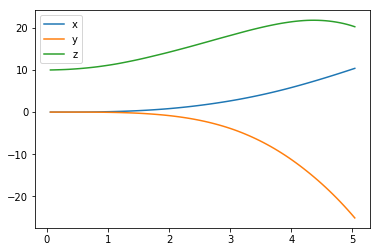

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

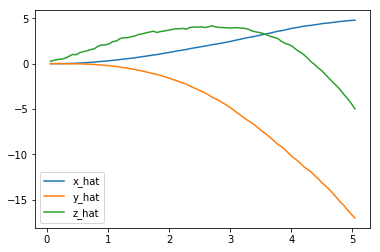

In [54]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, we can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

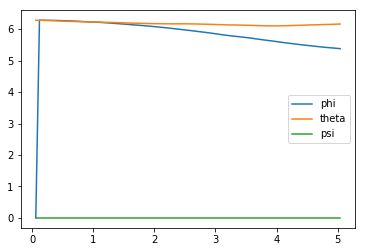

In [55]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

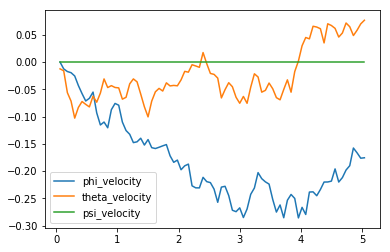

In [56]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, we can use the code cell below to print the agent's choice of actions.  

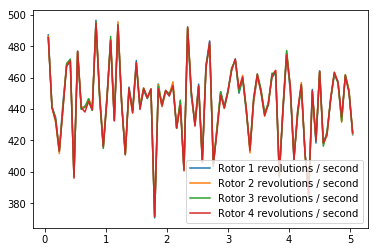

In [57]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, we will derive the environment state from the simulator.we  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [58]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ 10.38911166 -25.1436108   20.28347642   5.38061406   6.16287321   0.        ]
[  4.78561669 -17.00314493  -4.98195963]
[-0.17554989  0.07688083  0.        ]


In [64]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 500
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =  500, score =   3.335 (best =   4.857), noise_scale = 3.255

This agent should perform very poorly on this task.  And that's why we will now design a better agent!

In [67]:
#This is our agent that will perform much better
#TAKE OFF
import sys
import pandas as pd

from task import Task
from agents.agent import DDPG
num_episodes = 1000
init_pos=[0.,0.,0.,0.,0.,0]

target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = DDPG(task) 
reward_labels = ['episode', 'reward']
reward_results = {x : [] for x in reward_labels}
filename='rewards.txt'
best_total_reward=0
for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    total_reward=0
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        total_reward+=reward
        if total_reward>best_total_reward:
            best_total_reward=total_reward
        agent.step(action,reward,next_state, done)
        state = next_state
        if done:
            with open(filename,'a') as file:
                file.write(str(total_reward) + '\n')
                
            
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f})".format(
                i_episode, total_reward, best_total_reward), end="")  
            
            
            break
    reward_results['episode'].append(i_episode)
    reward_results['reward'].append(total_reward)
    sys.stdout.flush()

Episode = 1000, score = 114.850 (best = 224.505))

In [80]:
print(np.mean(reward_results['reward'][-20:]))

84.1194925656


## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

Text(0,0.5,'reward')

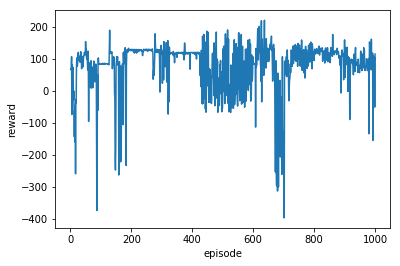

In [76]:


import  matplotlib.pyplot  as plt
%matplotlib inline

plt.plot(reward_results['episode'], reward_results['reward'])
plt.xlabel('episode')
plt.ylabel('reward')

